# Understanding the Script 

(Notes taken from: (Notes taken from https://towardsdatascience.com/extract-knowledge-from-text-end-to-end-information-extraction-pipeline-with-spacy-and-neo4j-502b2b1e0754))

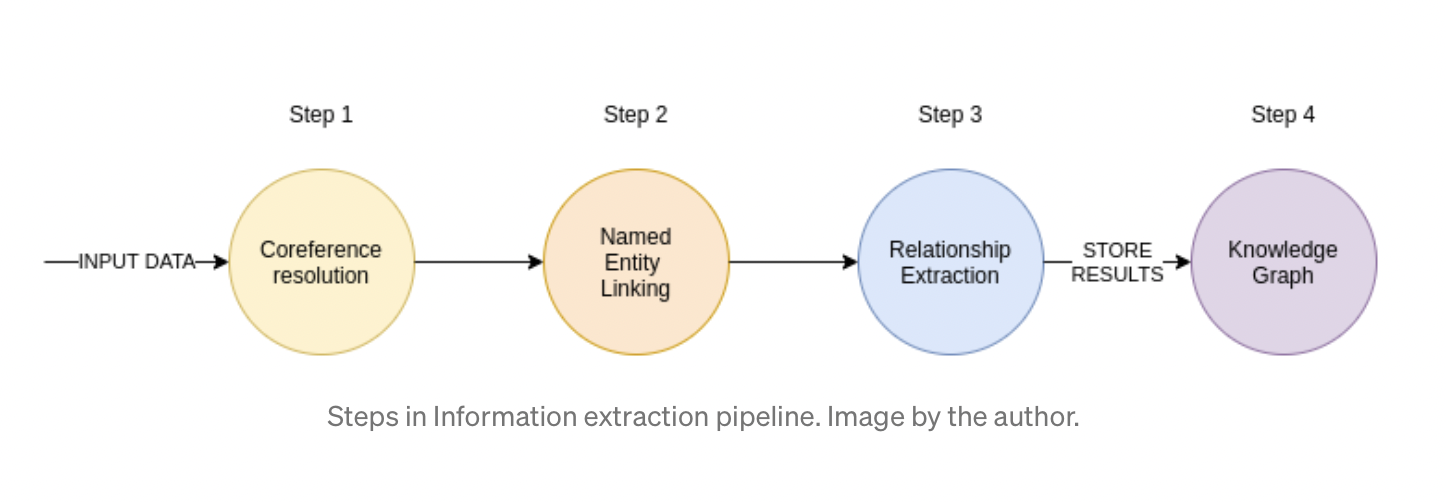

1. Coreference Resolution

- converts pronouns into referred entities
- most common: personal pronouns where the model replaces pronouns with the referred person’s name

2. Named Entity Linking

- identifying what entities to extract (depends on the problem question and desired information)
- common entities to identify: people, organizations, and locations
- linking involves standardizing entities by identifying entities that refer to the same concept
- extracted entities from the text are mapped to corresponding unique ids from a target knowledge base

(NOTE: what target knowledge base are we going to use?? This example uses Wikipedia)

3. Relationship Extraction

- identify any relationships between text that are mentioned in the text

# Pipeline Setup

In [1]:
!pip install --upgrade google-cloud-storage
!pip install transformers==4.18.0
!pip install crosslingual-coreference==0.2.3 spacy-transformers==1.1.5 wikipedia neo4j
!python -m spacy download en_core_web_sm
!pip install keras==2.6

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 106 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 2.0 MB/s  eta 0:00:01
     |████████████████████████████████| 175 kB 44.2 MB/s eta 0:00:01
     |████████████████████████████████| 115 kB 44.9 MB/s eta 0:00:01
     |████████████████████████████████| 211 kB 44.4 MB/s eta 0:00:01
     |████████████████████████████████| 408 kB 46.6 MB/s eta 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.6.0 requires google-auth<2,>=1.6.3, but you have google-auth 2.14.0 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 4.0 MB 4.3 MB/s eta 0:00:01
     |████████████████████████████████| 880 kB 45.2 MB/s eta 0:00:01
  Created wheel

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |███████████████████████████▉    | 767.9 MB 165.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 881.9 MB 6.9 kB/s 
     |████████████████████████████████| 2.9 MB 41.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 44.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 41.1 MB/s eta 0:00:01
     |████████████████████████████████| 1.8 MB 42.7 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 45.2 MB/s eta 0:00:01
     |████████████████████████████████| 316 kB 46.7 MB/s eta 0:00:01
     |████████████████████████████████| 17.1 MB 49.6 MB/s eta 0:00:01
     |████████████████████████████████| 52 kB 1.3 MB/s  eta 0:00:01
     |████████████████████████████████| 33.8 MB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 42.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 42.5 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 1.4 MB/s  eta 0:00:01
     |████████████████████████████████| 248 

Restart Kernal at this point

# Developing IE pipeline in spaCy

## Installing TwoKilos Data

In [ ]:
import pandas as pd
import spacy
import crosslingual_coreference
import requests
import re
import hashlib
from spacy import Language
from typing import List
from collections import defaultdict
from spacy.tokens import Doc, Span
from transformers import pipeline
import tagme

In [1]:
import pandas as pd
df = pd.read_csv('~/TAI/Users/kmealey2/data/tk_full_datasets/pd_no_meter.csv',encoding='latin-1')
df_small = df.head(10)

In [2]:
pd.set_option('display.max_columns', None)
df_small.head()

,index,equipmentNomenclature,problemDescription
0,0,AN/SLQ-32,S/F DISCOVERED THAT PDF CAL SCORES WERE LOW S/...
1,2,"CONSOLE, DISPLAY",ON 23FEB21 A HEAVY OBJECT FELL ON THE CEM DAMA...
2,4,"CABINET, ELECTRI",WHILE CONDUCTING OPERABILITY TEST IT WAS DISCO...
3,6,AN/SLQ-32,DURING NORMAL OPERATIONS S/F DISCOVERED SLQ32 ...
4,7,"ENCLOSURE, COUNT","DURING NORMAL OPERATIONS, S/F DISCOVERED THAT ..."


## Coreference Resolution

In [3]:
#Spacy - an open-source software library for advanced natural language processing
#https://spacy.io
import spacy
#Crosslingual_coreference - coreference model from SpaCy Universe (a collection of open-source plugins or addons for spaCy)
import crosslingual_coreference

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /afs/crc.nd.edu/user/k/khill9/nltk_data...


In [4]:
DEVICE = 0 # Number of the GPU, -1 if want to use CPU

# Loading en_core_web_sm 
    #English pipeline optimized for CPU
    #Disabled pipes will be loaded but they won’t be run unless you explicitly enable them
coref = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer'])

# Add coreference resolution model as shown in documentation
#https://spacy.io/universe/project/crosslingualcoreference
coref.add_pipe(
    "xx_coref", config={"chunk_size": 2500, "chunk_overlap": 2, "device": DEVICE})

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/489 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/225M [00:00<?, ?B/s]

Some weights of the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large were not used when initializing XLMRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaModel were not initialized from the model checkpoint at nreimers/mMiniLMv2-L12-H384-distilled-from-XLMR-Large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-st

## Named Entity Linking

using rebel
- github link: https://github.com/Babelscape/rebel/blob/main/spacy_component.py
- paper link: https://github.com/Babelscape/rebel/blob/main/docs/EMNLP_2021_REBEL__Camera_Ready_.pdf

In [5]:
# allows us to make a request to a web page
import requests
# provides regular expression matching operations
import re
# implements a common interface to many different secure hash and message digest algorithms
import hashlib
# text processing pipeline
from spacy import Language
from typing import List
from collections import defaultdict

from spacy.tokens import Doc, Span

from transformers import pipeline

import tagme
# Set the authorization token for subsequent calls.
tagme.GCUBE_TOKEN = "bb240233-c659-4da2-baac-ea752b444ef5-843339462"

def enwiki_title_to_wikidata_id(title: str) -> str:
    try:
        protocol = 'https'
        base_url = 'en.wikipedia.org/w/api.php'
        params = f'action=query&prop=pageprops&format=json&titles={title}'
        url = f'{protocol}://{base_url}?{params}'

        response = requests.get(url)
        json = response.json()
        for pages in json['query']['pages'].values():
            wikidata_id = pages['pageprops']['wikibase_item']
        return wikidata_id
    except:
        return 'id-less'



def call_wiki_api(item, text):
  # try:
    ann_dict = defaultdict(list)
    anns = tagme.annotate(text)
    for ann in anns.get_annotations(0.05):
        ann_dict[ann.mention].append(ann.entity_title)
    if item in ann_dict.keys():
        mylist = list(dict.fromkeys(ann_dict[item]))
        if len(mylist) != 0:
            return enwiki_title_to_wikidata_id(ann_dict[item][0])
        # else:
            # ids = ""
            # for entity in ann_dict[item]:
            #     ids = ids + enwiki_title_to_wikidata_id(entity) + ", "
            # return ids
            
            
                
    else:
        return 'id-less'
  # except:
  #   return 'error'

def extract_triplets(text):
    """
    Function to parse the generated text and extract the triplets
    """
    triplets = []
    relation, subject, relation, object_ = '', '', '', ''
    #removes white space on the front and backends of the text
    text = text.strip()
    current = 'x'
    for token in text.replace("<s>", "").replace("<pad>", "").replace("</s>", "").split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        triplets.append({'head': subject.strip(), 'type': relation.strip(),'tail': object_.strip()})

    return triplets


@Language.factory(
    "rebel",
    requires=["doc.sents"],
    assigns=["doc._.rel"],
    default_config={
        "model_name": "Babelscape/rebel-large",
        "device": 0,
    },
)
class RebelComponent:
    def __init__(
        self,
        nlp,
        name,
        model_name: str,
        device: int,
    ):
        assert model_name is not None, ""
        self.triplet_extractor = pipeline("text2text-generation", model=model_name, tokenizer=model_name, device=device)
        self.entity_mapping = {}
        # Register custom extension on the Doc
        if not Doc.has_extension("rel"):
          Doc.set_extension("rel", default={})

    def get_wiki_id(self, doc: Doc, item: str) -> str:
        mapping = self.entity_mapping.get(item)
        if mapping:
          return mapping
        else:
          res = call_wiki_api(item, doc.text)
          self.entity_mapping[item] = res
          return res

    
    def _generate_triplets(self, sent: Span) -> List[dict]:
          output_ids = self.triplet_extractor(sent.text, return_tensors=True, return_text=False)[0]["generated_token_ids"]["output_ids"]
          extracted_text = self.triplet_extractor.tokenizer.batch_decode(output_ids[0])
          extracted_triplets = extract_triplets(extracted_text[0])
          return extracted_triplets
   
    # handles how we store the results back to the spaCy’s Doc object
    
    def set_annotations(self, doc: Doc, triplets: List[dict]):
        for triplet in triplets:

            # Remove self-loops (relationships that start and end at the entity)
            if triplet['head'] == triplet['tail']:
                continue

            # Use regex to search for entities
            #searches doc.text for head
            head_span = re.search(triplet["head"], doc.text)
            #searches doc.text for tail
            tail_span = re.search(triplet["tail"], doc.text)

            # Skip the relation if both head and tail entities are not present in the text
            # Sometimes the Rebel model hallucinates some entities
            if not head_span or not tail_span:
              continue

            index = hashlib.sha1("".join([triplet['head'], triplet['tail'], triplet['type']]).encode('utf-8')).hexdigest()
            if index not in doc._.rel:
                # Get wiki ids and store results
                #doc._.rel[index] = {"relation": triplet["type"], "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(doc, triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(doc, triplet['tail'])}}
                doc._.rel[index] = {"relation_span": {'text': triplet["type"], 'id': self.get_wiki_id(doc, triplet["type"])}, "head_span": {'text': triplet['head'], 'id': self.get_wiki_id(doc, triplet['head'])}, "tail_span": {'text': triplet['tail'], 'id': self.get_wiki_id(doc, triplet['tail'])}}

    def __call__(self, doc: Doc) -> Doc:
        for sent in doc.sents:
            sentence_triplets = self._generate_triplets(sent)
            self.set_annotations(doc, sentence_triplets)
        return doc

ModuleNotFoundError: No module named 'tagme'

In [6]:
# Define rel extraction model

rel_ext = spacy.load('en_core_web_sm', disable=['ner', 'lemmatizer', 'attribute_rules', 'tagger'])
rel_ext.add_pipe("rebel", config={
    'device':DEVICE, # Number of the GPU, -1 if want to use CPU
    'model_name':'Babelscape/rebel-large'} # Model used, will default to 'Babelscape/rebel-large' if not given
    )



# Implementing Pipeline on TwoKilos DS

In [7]:
#for i in range(len(df)):
for i in range(3, 7):
    input_text = df['problemDescription'].iloc[i]

    coref_text = coref(input_text)._.resolved_text

    doc = rel_ext(coref_text)

    for value, rel_dict in doc._.rel.items():
        print(i)
        print(df['problemDescription'].iloc[i])
        print(rel_dict['head_span']['text'])
        print(rel_dict['head_span']['id'])
        print(rel_dict['relation_span']['text'])
        print(rel_dict['relation_span']['id'])
        print(rel_dict['tail_span']['text'])
        print(rel_dict['tail_span']['id'])
        print("\n")

3
DURING NORMAL OPERATIONS S/F DISCOVERED SLQ32 WOULD NO LONGER INITIALIZE UPON INSPECTION S/F FOUND BLADE 2 IN CPS DID NOT HAVE PROPER POWER LEVELS, CAUSING CASCADING FAILURES IN AMM S/F REMOVED BLADE 2 AND INSTALLED SPARE BLADE WHILE CLEARING THE FAULTS SYSTEM STILL FAILS TO BOOT
SLQ32
id-less
manufacturer
id-less
AMM
id-less


3
DURING NORMAL OPERATIONS S/F DISCOVERED SLQ32 WOULD NO LONGER INITIALIZE UPON INSPECTION S/F FOUND BLADE 2 IN CPS DID NOT HAVE PROPER POWER LEVELS, CAUSING CASCADING FAILURES IN AMM S/F REMOVED BLADE 2 AND INSTALLED SPARE BLADE WHILE CLEARING THE FAULTS SYSTEM STILL FAILS TO BOOT
CLEARING THE FAULTS SYSTEM
id-less
has part
id-less
CLEARING THE FAULTS SYSTEM STILL FAILS TO BOOT
id-less


4
DURING NORMAL OPERATIONS, S/F DISCOVERED THAT THE PDU IN THE STARBOARD ANTENNA WAS FAULTY AND NEEDS TO BE REPLACED
PDU
id-less
part of
id-less
STARBOARD ANTENNA
id-less


4
DURING NORMAL OPERATIONS, S/F DISCOVERED THAT THE PDU IN THE STARBOARD ANTENNA WAS FAULTY AND NEEDS T

In [8]:
index_list = []
text_list = []
head_list = []
headid_list = []
relation_list = []
relationid_list = []
tail_list = []
tailid_list = []

for i in range(len(df)):
    
    try:
        input_text = df['problemDescription'].iloc[i]

        coref_text = coref(input_text)._.resolved_text

        doc = rel_ext(coref_text)

        for value, rel_dict in doc._.rel.items():
            index_list.append(i)
            text_list.append(df['problemDescription'].iloc[i])
            head_list.append(rel_dict['head_span']['text'])
            headid_list.append(rel_dict['head_span']['id'])
            relation_list.append(rel_dict['relation_span']['text'])
            relationid_list.append(rel_dict['relation_span']['id'])
            tail_list.append(rel_dict['tail_span']['text'])
            tailid_list.append(rel_dict['tail_span']['id'])
        print(i)
            
    except Exception as e:
        print(i)
        print(f"Couldn't parse text due to {e}")

0
1


/afs/crc.nd.edu/user/a/asticha/.local/lib/python3.9/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

/afs/crc.nd.edu/user/a/asticha/.local/lib/python3.9/site-packages/allennlp/modules/token_embedders/pretrained_transformer_embedder.py:385: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  num_effective_segments = (seq_lengths + self._max_length - 1) // self._max_length


1186
1187
1188
1189
1190
1191
1192
1193
1194
1195
1196
1197
1198
1199
1200
1201
1202
1203
1204
1205
1206
1207
1208
1209
1210
1211
1212
1213
1214
1215
1216
1217
1218
1219
1220
1221
1222
1223
1224
1225
1226
1227
1228
1229
1230
1231
1232
1233
1234
1235
1236
1237
1238
1239
1240
1241
1242
1243
1244
1245
1246
1247
1248
1249
1250
1251
1252
1253
1254


In [9]:
len(index_list)

2606

In [10]:
df_results = pd.DataFrame()

In [11]:
df_results['index'] = index_list
df_results['text'] = text_list 
df_results['head'] = head_list 
df_results['headid'] = headid_list
df_results['relation'] = relation_list
df_results['relationid'] = relationid_list
df_results['tail'] = tail_list 
df_results['tailid'] = tailid_list

In [12]:
df_results.to_csv('~/TAI/Users/abbysticha/data/IE tutorials/tagme_clean.csv', index = False)

## Visualising using Neo4j

In [1]:
from neo4j import GraphDatabase, basic_auth
import pandas as pd

driver = GraphDatabase.driver(
  "bolt://54.158.54.163:7687",
  auth=basic_auth("neo4j", "stools-pads-routes"))

def run_query(query, params={}):
    with driver.session(database="neo4j") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())


In [2]:
import_query = """
UNWIND $data AS row
MERGE (h:Entity {id: CASE WHEN NOT row.head_span.id = 'id-less' THEN row.head_span.id ELSE row.head_span.text END})
ON CREATE SET h.text = row.head_span.text
MERGE (t:Entity {id: CASE WHEN NOT row.tail_span.id = 'id-less' THEN row.tail_span.id ELSE row.tail_span.text END})
ON CREATE SET t.text = row.tail_span.text
WITH row, h, t
CALL apoc.merge.relationship(h, toUpper(replace(row.relation,' ', '_')), {}, {}, t, {})
YIELD rel
RETURN distinct 'done' AS result;
"""

def store_problem_summary(i):
  try:
    input_text = df['problemDescription'].iloc[i]
    coref_text = coref(input_text)._.resolved_text
    doc = rel_ext(coref_text)
    params = [rel_dict for value, rel_dict in doc._.rel.items()]
    run_query(import_query, {'data': params})
  except Exception as e:
    print(f"Couldn't parse text due to {e}")

In [3]:
for i in range(len(df)):
  print(f"Parsing {i}")
  store_problem_summary(i)

NameError: name 'df' is not defined

## Enriching the graph

In [16]:
DEVICE = 0 # Number of the GPU, -1 if want to use CPU

from neo4j import unit_of_work
@unit_of_work(timeout=400)
def run_query1(query, params={}):
    with driver.session(database="neo4j") as session:
        result = session.run(query, params)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

run_query1("""
CALL apoc.periodic.iterate("
  // Match all entities that have a Wiki Id
  MATCH (e:Entity)
  WHERE e.id STARTS WITH 'Q'
  RETURN e
","
  // Prepare a SparQL query
  WITH 'SELECT * WHERE{ ?item rdfs:label ?name . filter (?item = wd:' + e.id + ') filter (lang(?name) = \\\"en\\\") ' +
     'OPTIONAL {?item wdt:P31 [rdfs:label ?label] .filter(lang(?label)=\\\"en\\\")}}' AS sparql, e
  // make a request to Wikidata
  CALL apoc.load.jsonParams(
    'https://query.wikidata.org/sparql?query=' + 
      sparql,
      { Accept: 'application/sparql-results+json'}, null)
  YIELD value
  UNWIND value['results']['bindings'] as row
  SET e.wikipedia_name = row.name.value
  WITH e, row.label.value AS label
  MERGE (c:Class {id:label})
  MERGE (e)-[:INSTANCE_OF]->(c)
  RETURN distinct 'done'", {batchSize:1, retry:5})
""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,417,417,34,0,417,417,0,{'Server returned HTTP response code: 400 for ...,"{'total': 417, 'committed': 0, 'failed': 417, ...","{'total': 417, 'committed': 0, 'failed': 417, ...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."
